In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#필요한 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as pylab
from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float

from keras import layers
from keras import models
from keras.utils import np_utils  # to_categorical
from sklearn.model_selection import train_test_split

import cv2
import os

from keras import optimizers
import tensorflow as tf

In [3]:
W = 244
H = 244
F = 1
Nout = 351

epochs=100
batch_size=100

# 탐지 결과를 위한 함수들

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
# 추후에 쓰면 좋을 것

# plot 그래프

In [5]:
# 학습 결과 분석을 위한 그래프 구현

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['loss'])             # 학습 데이터로 구한 손실값
  plt.plot(history['val_loss'])         # 검증 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)

# 데이터 불러오기

In [6]:
train_dir = './drive/MyDrive/02_face_training'
filenames = os.listdir(train_dir)

faces = []
labels = []

for filename in filenames[:-1]:
    label = filename[0:4]
    image = cv2.imread(train_dir+'/'+filename, 0)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = np.array(image).reshape((-1, W, H, 3))
    image = cv2.resize(image, (W,H))
    faces.append(image)
    labels.append(int(label))

faces = np.asarray(faces)
faces = faces.astype('float32')

# 1~9의 숫자로 된 출력값을 이진수(0/1)로 표현되는 벡터로 바꿈 (더 효율적)
# 원핫인코딩
labels = np_utils.to_categorical(labels, num_classes = Nout)

faces = faces.reshape(-1,W,H,1)
faces = faces / 255.

train_X, test_X, train_Y, test_Y = train_test_split(faces, labels, test_size=0.2, random_state=13)


In [7]:
faces.shape

(1049, 244, 244, 1)

In [8]:
labels.shape

(1049, 351)

# 모델 시도 0 : 오토 인코더

In [ ]:
model = models.Sequential([
  # Encoder
  layers.Conv2D(32, (2,2), activation='relu', padding="same", input_shape=(W, H, F)),
  layers.MaxPooling2D(pool_size=(1,1)),
  # layers.Conv2D(32, (2,2), activation='relu', padding="same"),
  # layers.MaxPooling2D(pool_size=(1,1)),
  # layers.Conv2D(32, (2,2), activation='relu', padding="same"),
  # Decoder
  layers.Conv2D(32, (2,2), activation='relu', padding="same"),
  layers.UpSampling2D((2,2)),
  layers.Conv2D(32, (2,2), activation='relu', padding="same"),
  layers.UpSampling2D((1,1)),
  layers.Flatten(),
  layers.Dense(Nout, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

ResourceExhaustedError: ignored

# 모델 시도 1 : CNN

In [ ]:
rate = 0.5

model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(W, H, F)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(rate),

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Flatten(),
  layers.Dropout(rate),
  layers.Dense(512, activation='relu'),
  layers.Dropout(rate),
  layers.Dense(Nout, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 144, 144, 64)      640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 144, 144, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 72, 72, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 70, 70, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 64)       

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

# 모델 시도 2 : CNN

In [ ]:
model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(W, H, F)),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer = 'glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0)),
  layers.Dropout(0.5),
  layers.Dense(Nout, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 144, 144, 64)      640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 72, 72, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 70, 70, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 33, 128)      

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

# 모델 시도 3 : Resnet

In [ ]:
# 모델 출처: https://rarena.tistory.com/entry/keras-%ED%8A%B9%EC%A0%95-%EB%AA%A8%EB%8D%B8%EB%A1%9C%EB%93%9C%ED%95%98%EC%97%AC-%EB%82%B4-%EB%A0%88%EC%9D%B4%EC%96%B4

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from tensorflow.keras.applications import ResNet34, preprocess_input, decode_predictions

input = layers.Input(shape=(W,H,F))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')

x = model.output
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(Nout, activation='softmax', name='softmax')(x)
model = models.Model(model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

# 모델 시도4 : Resnet 직접 함수 구현

In [9]:
# 모델 출처: https://eremo2002.tistory.com/76

from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math

 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(2):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(2):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(2):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(2):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x


In [10]:
from keras.optimizers import Adam
def ResNet(W, H, F, Nout):
  input_tensor = Input(shape=(W, H, F), dtype='float32', name='input')
  x = conv1_layer(input_tensor)
  x = conv2_layer(x)
  x = conv3_layer(x)
  x = conv4_layer(x)
  x = conv5_layer(x)
  x = GlobalAveragePooling2D()(x)
  output_tensor = Dense(Nout, activation='softmax', kernel_initializer='glorot_uniform')(x)
  
  model = Model(input_tensor, output_tensor)

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

# 모델 시도 5 : VGG16

In [ ]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model

In [ ]:
input_tensor = Input(shape=(W,H,F))
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output
# Cov2D Layer +
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)
# MaxPooling2D Layer +
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flatten Layer +
x = Flatten()(x)
# FC Layer +
x = Dense(2048, activation='relu', kernel_initializer = 'glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0))(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_initializer = 'glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0))(x)
x = Dropout(0.5)(x)
x = Dense(Nout, activation='softmax')(x)

# new model 정의
model = Model(inputs = model.input, outputs = x)

In [ ]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in model.layers[:19] :
    layer.trainable = False

model.summary()

# 컴파일 옵션
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0  

# 모델 시도 6 : VGG16 다른거

In [ ]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(W, H, F))


In [ ]:
transfer_model.trainable=False

In [ ]:
model = models.Sequential([
    transfer_model, 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(Nout, 'softmax')
])

In [ ]:
model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy', precision, recall, f1score])

# 모델 시도 7 : resnet 종류별

In [19]:
NUM_CLASSES = Nout

In [22]:
import tensorflow as tf


class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.downsample = tf.keras.Sequential()
        self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride))
        self.downsample.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block

In [23]:
class ResNetTypeI(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeI, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


class ResNetTypeII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeII, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                            blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                            blocks=layer_params[1],
                                            stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                            blocks=layer_params[2],
                                            stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                            blocks=layer_params[3],
                                            stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


def resnet_18():
    return ResNetTypeI(layer_params=[2, 2, 2, 2])


def resnet_34():
    return ResNetTypeI(layer_params=[3, 4, 6, 3])


def resnet_50():
    return ResNetTypeII(layer_params=[3, 4, 6, 3])


def resnet_101():
    return ResNetTypeII(layer_params=[3, 4, 23, 3])


def resnet_152():
    return ResNetTypeII(layer_params=[3, 8, 36, 3])

In [31]:
input_tensor = layers.Input(shape=(W, H, F), dtype='float32', name='input')

# inputs, training=None, mask=None
model = resnet_18()
model.summary()

ValueError: ignored

In [ ]:
x = model.output
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(Nout, activation='softmax', name='softmax')(x)
model = Model(input_tensor, output_tensor)

In [ ]:
model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy', precision, recall, f1score])

# Train 돌리기

In [33]:
model = ResNet(W, H, F, Nout)

In [34]:
history = model.fit(
  train_X, train_Y,
  epochs=100,
  batch_size=80,
  validation_data=(test_X, test_Y),
  shuffle=True,
)

Epoch 1/100
11/11 [==============================] - 10s 631ms/step - loss: 7.0762 - accuracy: 0.0060 - val_loss: 5.8997 - val_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 6s 585ms/step - loss: 5.7182 - accuracy: 0.0224 - val_loss: 5.9108 - val_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 6s 588ms/step - loss: 5.1361 - accuracy: 0.0352 - val_loss: 5.9284 - val_accuracy: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 6s 587ms/step - loss: 4.5134 - accuracy: 0.0722 - val_loss: 6.1592 - val_accuracy: 0.0000e+00
Epoch 5/100
11/11 [==============================] - 6s 580ms/step - loss: 3.9630 - accuracy: 0.1333 - val_loss: 6.7951 - val_accuracy: 0.0048
Epoch 6/100
11/11 [==============================] - 6s 576ms/step - loss: 3.3137 - accuracy: 0.2489 - val_loss: 6.6084 - val_accuracy: 0.0048
Epoch 7/100
11/11 [==============================] - 6s 571ms/step - loss: 2.8262 - accuracy: 0.3604 - val_loss: 8.2219 - val

# Test 돌리기

In [35]:
loss, acc = model.evaluate(test_X, test_Y)

print("\nLoss: {}\nAcc: {}".format(loss, acc))

7/7 [==============================] - 1s 68ms/step - loss: 0.9219 - accuracy: 0.8619

Loss: 0.921866774559021
Acc: 0.8619047403335571


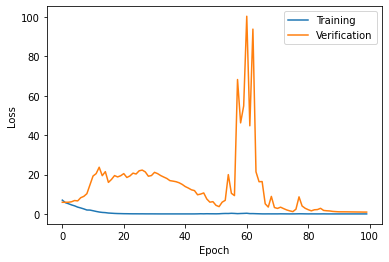

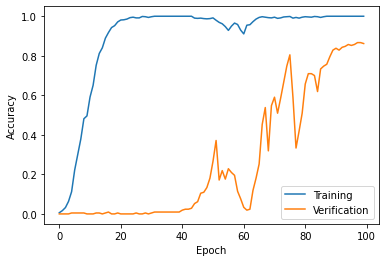

In [36]:
plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

# 교차 검증

In [20]:
from sklearn.model_selection import StratifiedKFold, KFold

## train

In [30]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# cross validation
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(train_X, train_Y):

  # Define the model architecture
  model = ResNet(W, H, F, Nout)

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(train_X[train], train_Y[train], epochs=100,batch_size=100, verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(train_X[test], train_Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 4.072591304779053; accuracy of 66.66666865348816%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 6.06595516204834; accuracy of 50.59523582458496%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 5.215511798858643; accuracy of 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 5.347583770751953; accuracy of 65.47619104385376%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 4.765905380249023; accuracy of 59.28143858909607%
------------------------------------------------------------------------
Score per fold
-------------------------------------------------------------

## test

In [31]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# cross validation
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(test_X, test_Y):

  # Define the model architecture
  model = model

  # # Generate a print
  # print('------------------------------------------------------------------------')
  # print(f'Training for fold {fold_no} ...')

  # # Fit data to model
  # history = model.fit(X_train[train], Y_train[train],
  #                     batch_size=batch_size,
  #                     epochs=epochs,
  #                     verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(test_X[test], test_Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Score for fold 1: loss of 4.87829065322876; accuracy of 59.52380895614624%
Score for fold 2: loss of 5.174448490142822; accuracy of 54.76190447807312%
Score for fold 3: loss of 3.2751901149749756; accuracy of 76.1904776096344%
Score for fold 4: loss of 3.197998046875; accuracy of 61.90476417541504%
Score for fold 5: loss of 4.115469932556152; accuracy of 64.28571343421936%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.87829065322876 - Accuracy: 59.52380895614624%
------------------------------------------------------------------------
> Fold 2 - Loss: 5.174448490142822 - Accuracy: 54.76190447807312%
------------------------------------------------------------------------
> Fold 3 - Loss: 3.2751901149749756 - Accuracy: 76.1904776096344%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.197998046875 - Accuracy: 61.

# 결과 제출

In [37]:
import csv

test_dir = './drive/MyDrive/02_face_test'
file_list = os.listdir(test_dir)

result = []

for file in file_list:
    name = file.split('.')[0]

    data = cv2.imread(test_dir+'/'+file, 0)

    data = cv2.resize(data, (W,H))
    data = np.asarray(data)
    data = data.astype('float32')

    data = data.reshape(-1,W,H,1)
    data = data / 255.

    pred = np.argmax(model.predict(data), axis=1)

    result.append([name, pred])


In [38]:
with open('./drive/MyDrive/1871063_김서영_얼굴_2차_답안.csv', 'w', newline='') as f:
  write = csv.writer(f)
  write.writerow(['Image', 'Answer'])
  write.writerows(result)